<div align='left' style="height:60px;overflow:hidden;">
<a href='http://www.ismar.cnr.it/index_html-1?set_language=en&cl=en'>
<img align='left' style='display: block;height: 92%' src='http://www.ismar.cnr.it/logo-en.jpg' alt='UFF logo' title='UFF logo'/>
</a>

# SOS server explorer
A Notebook to explore and visualize the data stored in a SOS Server (Version 2.0.0).

Author: Stefano Menegon, (http://www.ismar.cnr.it)



## Configuration

In [8]:
# configuration
SOS_URL = 'http://vesk.ve.ismar.cnr.it/observations/sos/kvp'
SOS_VERSION = '2.0.0'
DATE_START = '2017-01-01'
DATE_END = '2017-01-10'

## Load libraries
For more information see the documentation of the OWSLib python library:

https://geopython.github.io/OWSLib/


In [9]:
%matplotlib inline

import requests
from xml.etree import ElementTree

from pylab import rcParams
rcParams['figure.figsize'] = 13, 5

import numpy
import matplotlib.dates, matplotlib.pyplot

from datetime import date, datetime, timedelta
import simplejson as json
from dateutil.parser import parse

from owslib.sos import SensorObservationService

In [10]:
def get_pref_label(url):
    """A simple function to retrieve a label from a SKOS concept"""
    response = requests.get(url)
    tree = ElementTree.fromstring(response.content)
    namespaces = {'skos': 'http://www.w3.org/2004/02/skos/core#'}
    return tree.find('.//skos:prefLabel', namespaces=namespaces).text
    


## Initialization

In [11]:
sos = SensorObservationService(SOS_URL, version=SOS_VERSION)
# Fix a owslib vs. SOS52North issue
getob = sos.get_operation_by_name('getobservation')
getob.methods = {'Get': {'url': SOS_URL}}

## Print metadata

In [12]:
id = sos.identification

print "Service:"
print "\t", id.service, id.version
print "Title:"
print "\t", id.title
print "Abstract"
print "\t", id.abstract
print "Keywords"
print "\t", id.keywords

Service:
	OGC:SOS 1.0.0
Title:
	Starter Kit ISMAR Venezia
Abstract
	None
Keywords
	['ASD']


## Plot data


In [13]:
responseFormat     = 'application/json'
namespaces         = "xmlns(om,http://www.opengis.net/om/2.0)"
start_time          = date.today() - timedelta(days=140)
# temporalFilter     = "om:phenomenonTime,{}".format(start_time.isoformat())
temporalFilter = "om:phenomenonTime,{}T00:00:00+00:00/{}T00:00:00+01:00".format(DATE_START, 
                                                                                DATE_END)



http://vocab.nerc.ac.uk/collection/P01/current/CDTBZZ01/
Absolute temperature of the atmosphere


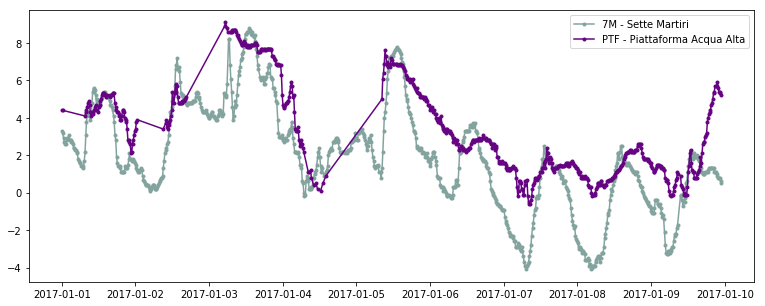



http://vocab.nerc.ac.uk/collection/P01/current/CPRPRG01/
Thickness of precipitation amount (liquid water equivalent) in the atmosphere by in-situ rain gauge


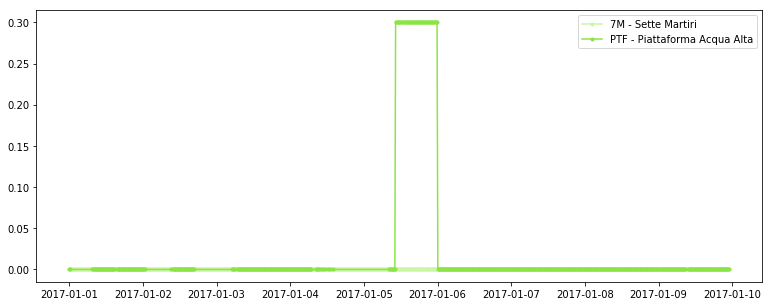



http://vocab.nerc.ac.uk/collection/P01/current/CPRRRG01/
Precipitation rate (liquid water equivalent) in the atmosphere by in-situ rain gauge


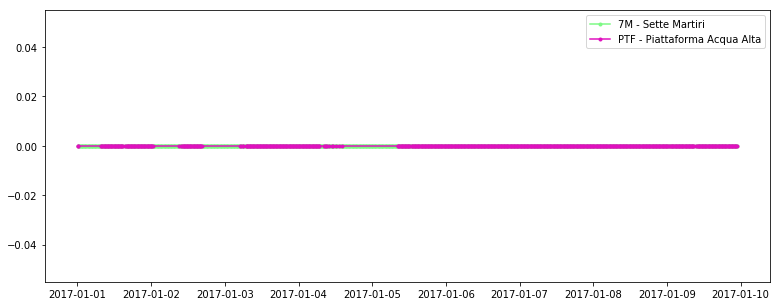



http://vocab.nerc.ac.uk/collection/P01/current/CRELZZ01/
Relative humidity of the atmosphere


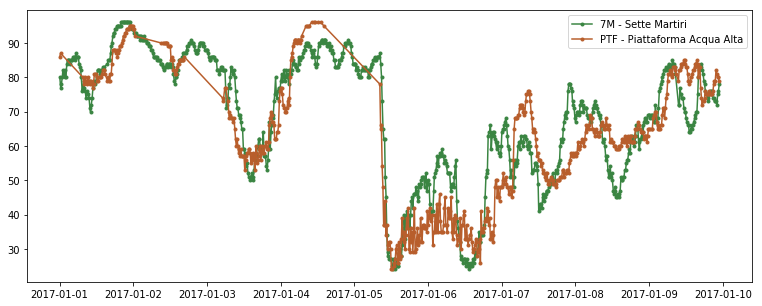



http://vocab.nerc.ac.uk/collection/P01/current/DBINAW01/
Depth below sea surface (acoustic doppler wave array bin) in the water body


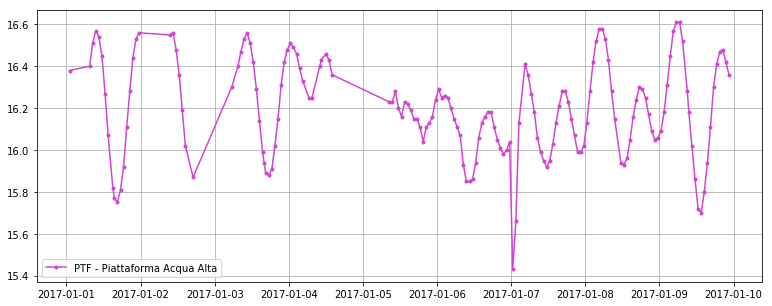



http://vocab.nerc.ac.uk/collection/P01/current/DEPHPREN/
Depth below surface (sampling event end) of the water body by profiling pressure sensor and conversion to depth using unspecified algorithm


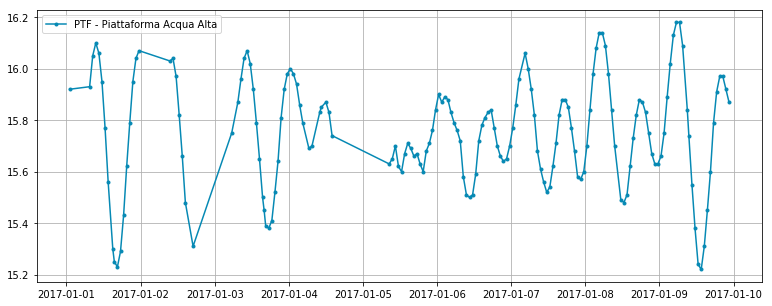



http://vocab.nerc.ac.uk/collection/P01/current/ERWDSS01/
Wind direction (relative to moving platform) in the atmosphere by in-situ anemometer


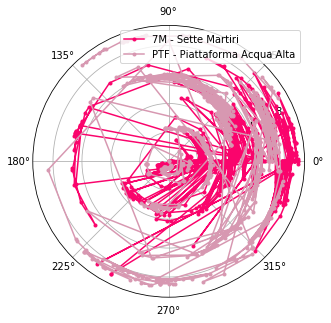



http://vocab.nerc.ac.uk/collection/P01/current/ERWSSS01/
Wind speed (relative to moving platform) in the atmosphere by in-situ anemometer


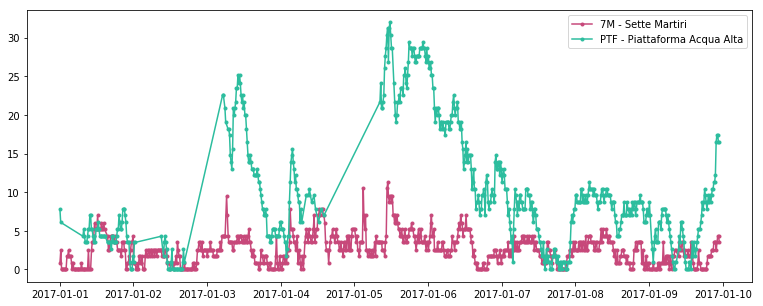



http://vocab.nerc.ac.uk/collection/P01/current/GAVHAD01/
Average height of waves (highest one third) on the water body by acoustic doppler wave array


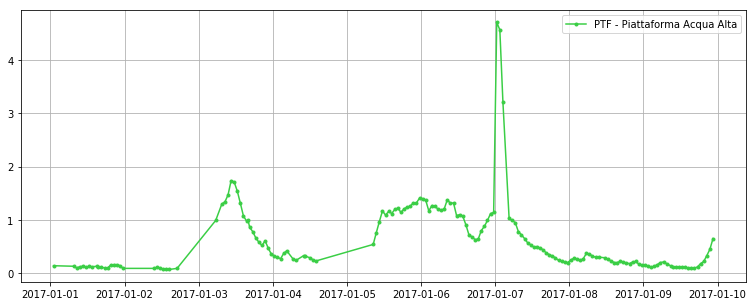



http://vocab.nerc.ac.uk/collection/P01/current/GCMXAD01/
Maximum height of waves on the water body by acoustic doppler wave array


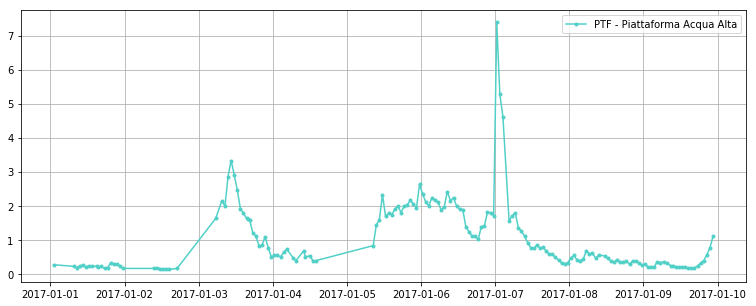



http://vocab.nerc.ac.uk/collection/P01/current/GDPXAD01/
Direction at spectral maximum of waves on the water body by acoustic doppler wave array


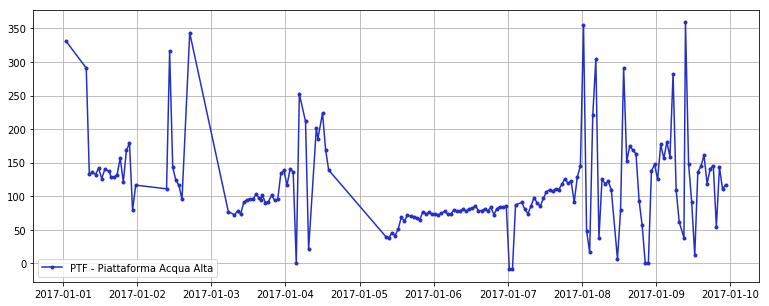



http://vocab.nerc.ac.uk/collection/P01/current/GHMZAD01/
Spectral significant height of waves {Hm0} on the water body by acoustic doppler wave array


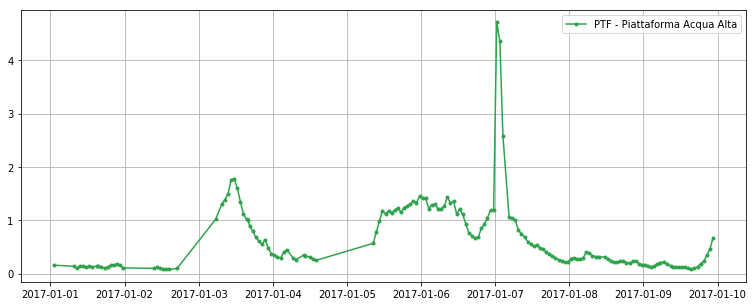



http://vocab.nerc.ac.uk/collection/P01/current/GSPRAD01/
Directional spreading of waves on the water body by acoustic doppler wave array


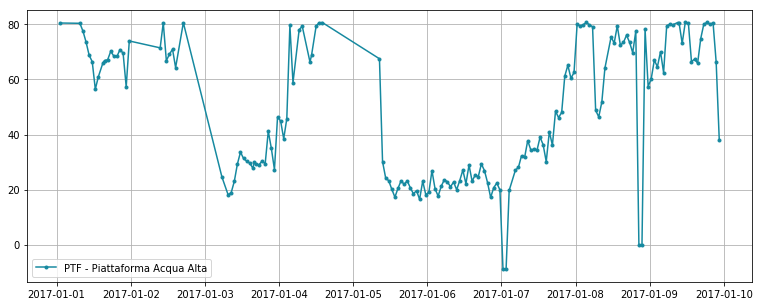



http://vocab.nerc.ac.uk/collection/P01/current/GTAMZD01/
Average period of waves on the water body by acoustic doppler wave array


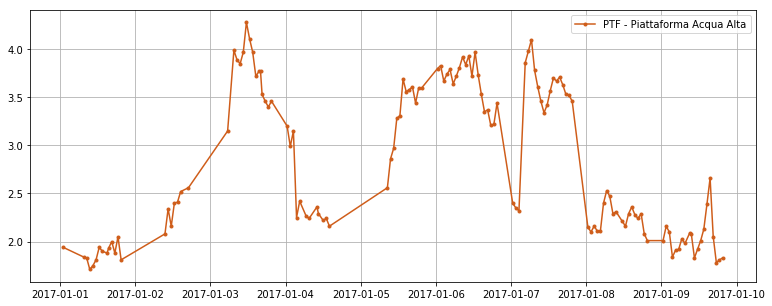



http://vocab.nerc.ac.uk/collection/P01/current/GTAVAD01/
Average zero crossing period of waves {Tz} on the water body by acoustic doppler wave array


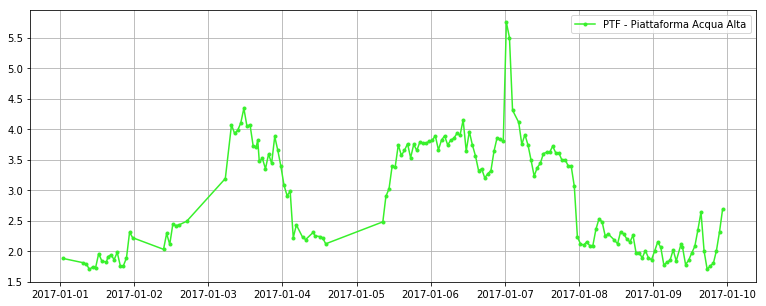



http://vocab.nerc.ac.uk/collection/P01/current/GTZLZZ01/
Average zero crossing period of waves (longest one third) on the water body


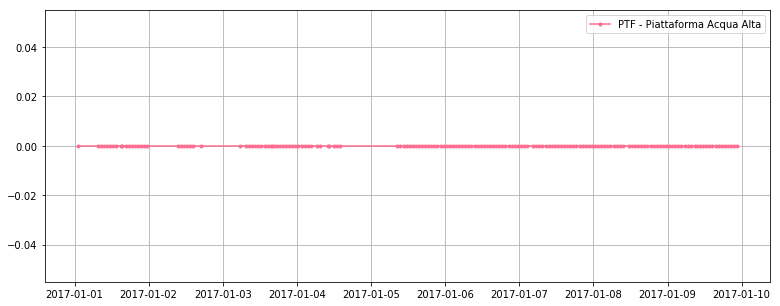



http://vocab.nerc.ac.uk/collection/P01/current/GTZMAP01/
Period at spectral maximum of waves on the water body by acoustic doppler wave array


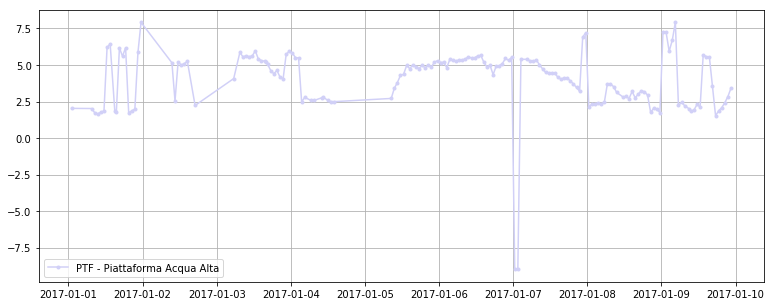



http://vocab.nerc.ac.uk/collection/P01/current/GWMDAD01/
Mean direction of waves on the water body by acoustic doppler wave array


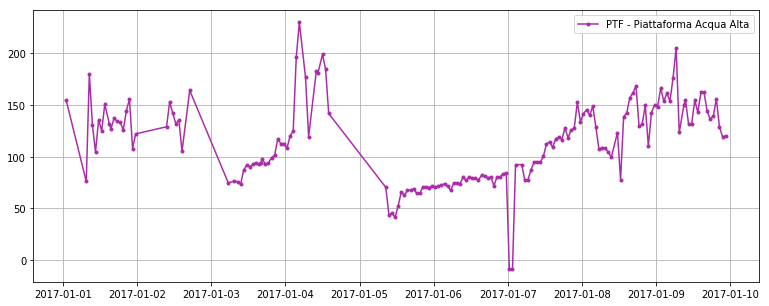



http://vocab.nerc.ac.uk/collection/P01/current/UWDRAD01/
Unidirectivity index of waves on the water body by acoustic doppler wave array and computation using protocol of Barstow et al. (1991)


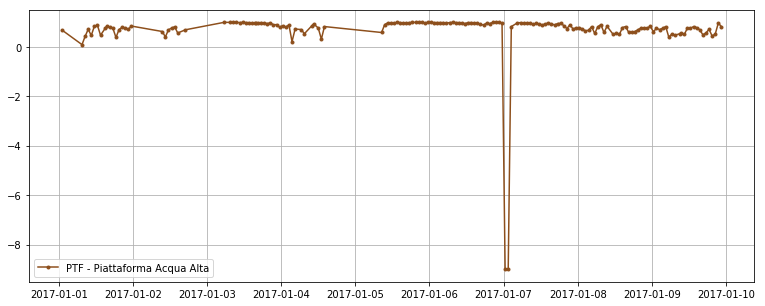



http://vocab.nerc.ac.uk/collection/P02/current/CAPH/
Air pressure


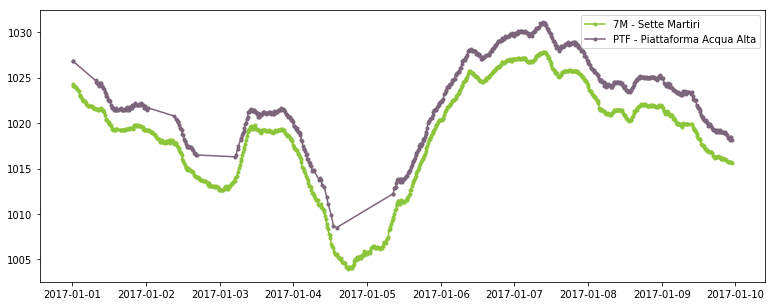



http://vocab.nerc.ac.uk/collection/P02/current/TEMP/
Temperature of the water column


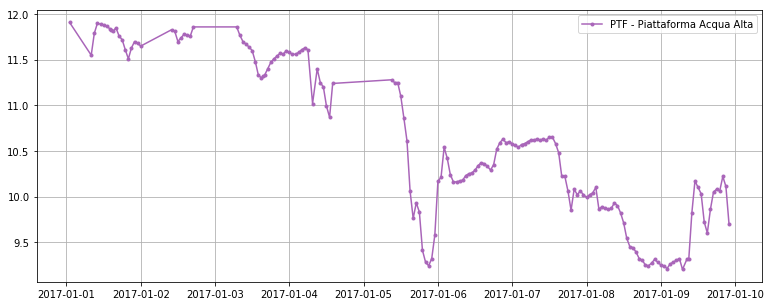

In [14]:
skips = ['http://www.opengis.net/def/property/OGC/0/PhenomenonTime',
         #'http://vocab.nerc.ac.uk/collection/P01/current/CPRPRG01/',
         #'http://vocab.nerc.ac.uk/collection/P01/current/EGTSSS01/'
        ]

observed_properties = [o for o in getob.parameters['observedProperty']['values'] if o not in skips]

for observed_property in observed_properties:
    
    observedProperties = [observed_property]
    
    res = sos.get_observation(offerings=sos.contents.keys(), 
                              responseFormat=responseFormat, 
                              observedProperties=observedProperties,            

                              namespaces=namespaces, 
                              eventTime=temporalFilter,
                              MergeObservationsIntoDataArray='true',
                             procedure=None)
    
    obs = json.loads(res)
    datas = [(o['featureOfInterest']['name']['value'], o['result']['values']) for o in obs['observations']]

    if len(datas) == 0:
        continue

    for label, values in datas:
        x = matplotlib.dates.date2num([parse(val[0]) for val in values])
        y = [val[1] for val in values]

        
        # mask -100
        y = numpy.ma.array(y)
        y_masked = numpy.ma.masked_where(y <= -100 , y)
            
        if observed_property == 'http://vocab.nerc.ac.uk/collection/P01/current/ERWDSS01/':
            matplotlib.pyplot.polar(numpy.radians(y_masked), x - numpy.amin(x), 
                                    '-bo', ms=3, 
                                    c=numpy.random.rand(3,1).flatten(), 
                                    label=label )
        else:
            matplotlib.pyplot.plot_date(x, y_masked, '-bo', ms=3, 
                                        c=numpy.random.rand(3,1).flatten(), 
                                        label=label )
            matplotlib.pyplot.grid()
    matplotlib.pyplot.legend()
    print "\n\n", observed_property
    print get_pref_label(observed_property)
    matplotlib.pyplot.show()
